# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(100)
%load_ext autoreload
%autoreload 2

# Source Generation and Mixing Scenario

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.7, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = False)

print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99966238544525


# Visualize Generated Sources and Mixtures

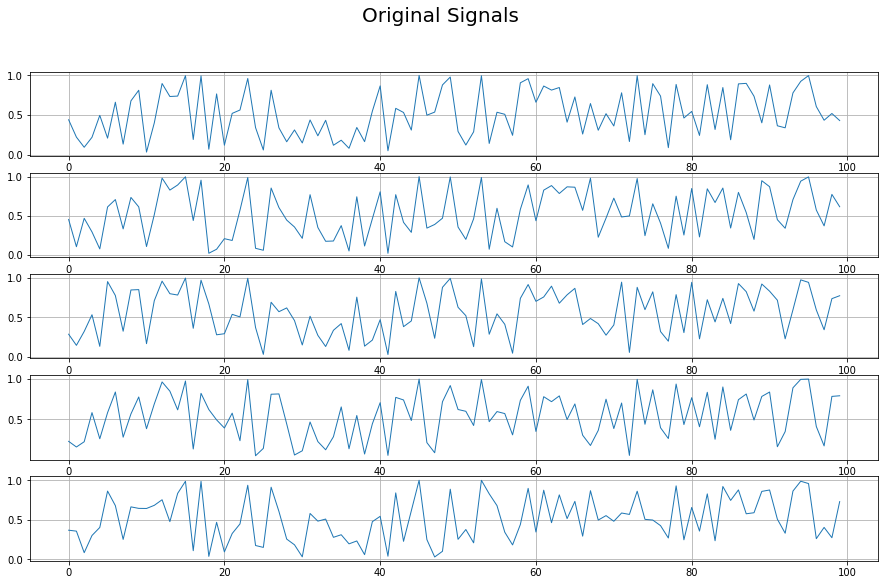

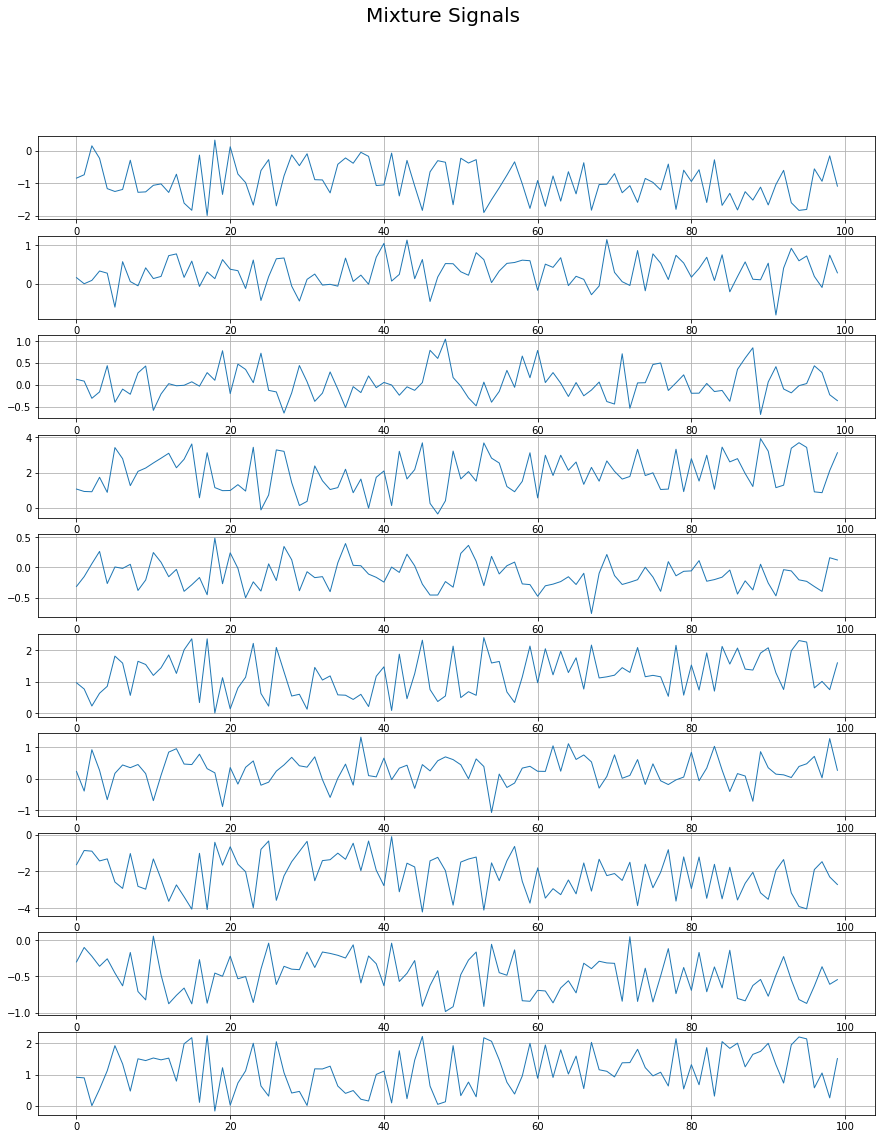

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
# HYPERPARAMETERS DEFINED IN THE PAPER
lambda_ = 0.99
mu_F = 1e-3
beta = 30
debug_iteration_point = 10000

model = OnlineBCA(s_dim = NumberofSources, x_dim = NumberofMixtures, 
                  lambda_ = lambda_, mu_F = mu_F, beta = beta, set_ground_truth = True, S = S, A = A)

# Run Online BCA Algorithm on Mixture Signals

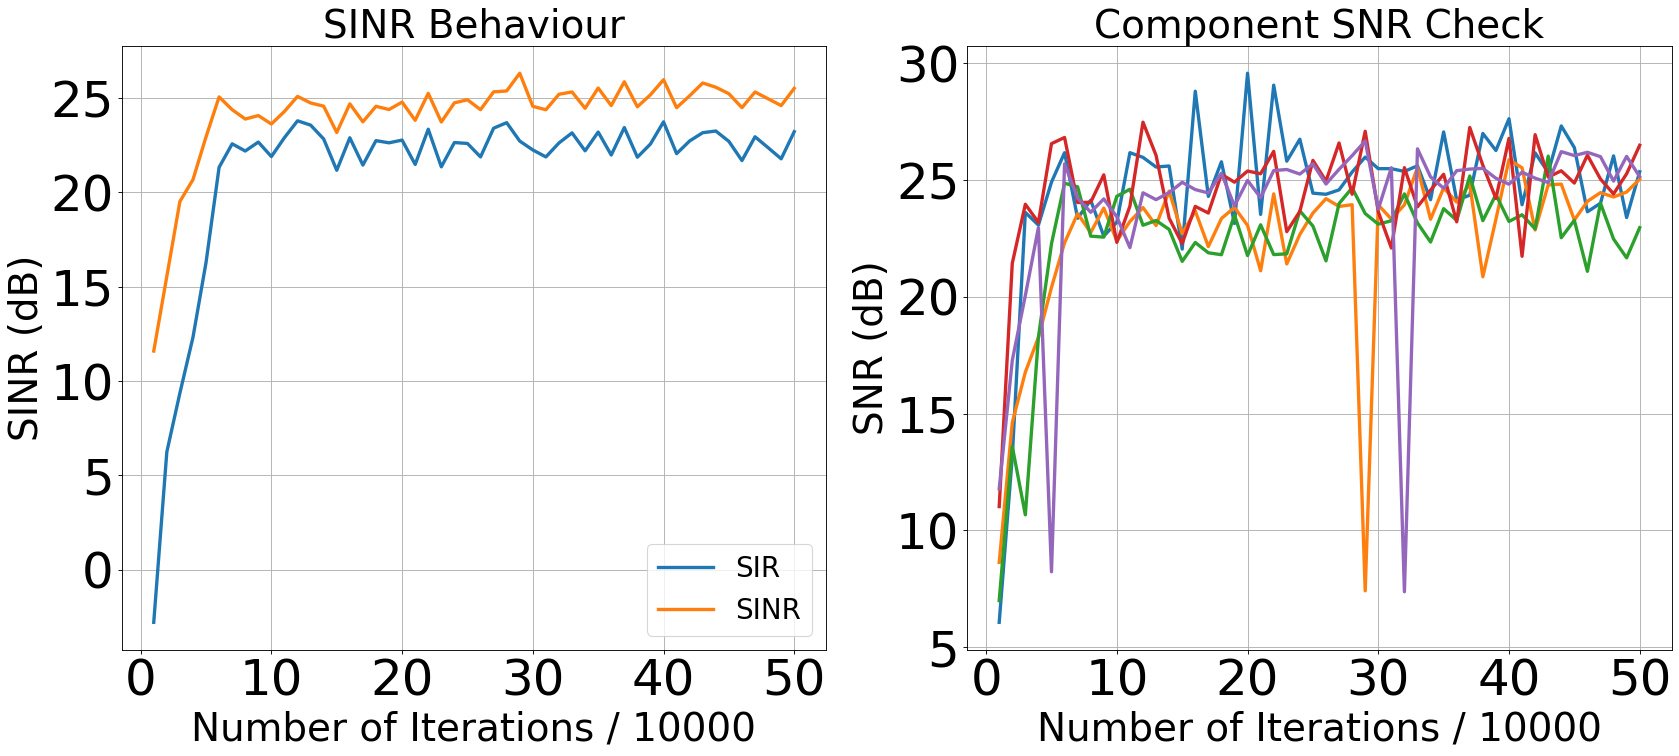

100%|██████████| 500000/500000 [02:00<00:00, 4148.35it/s]


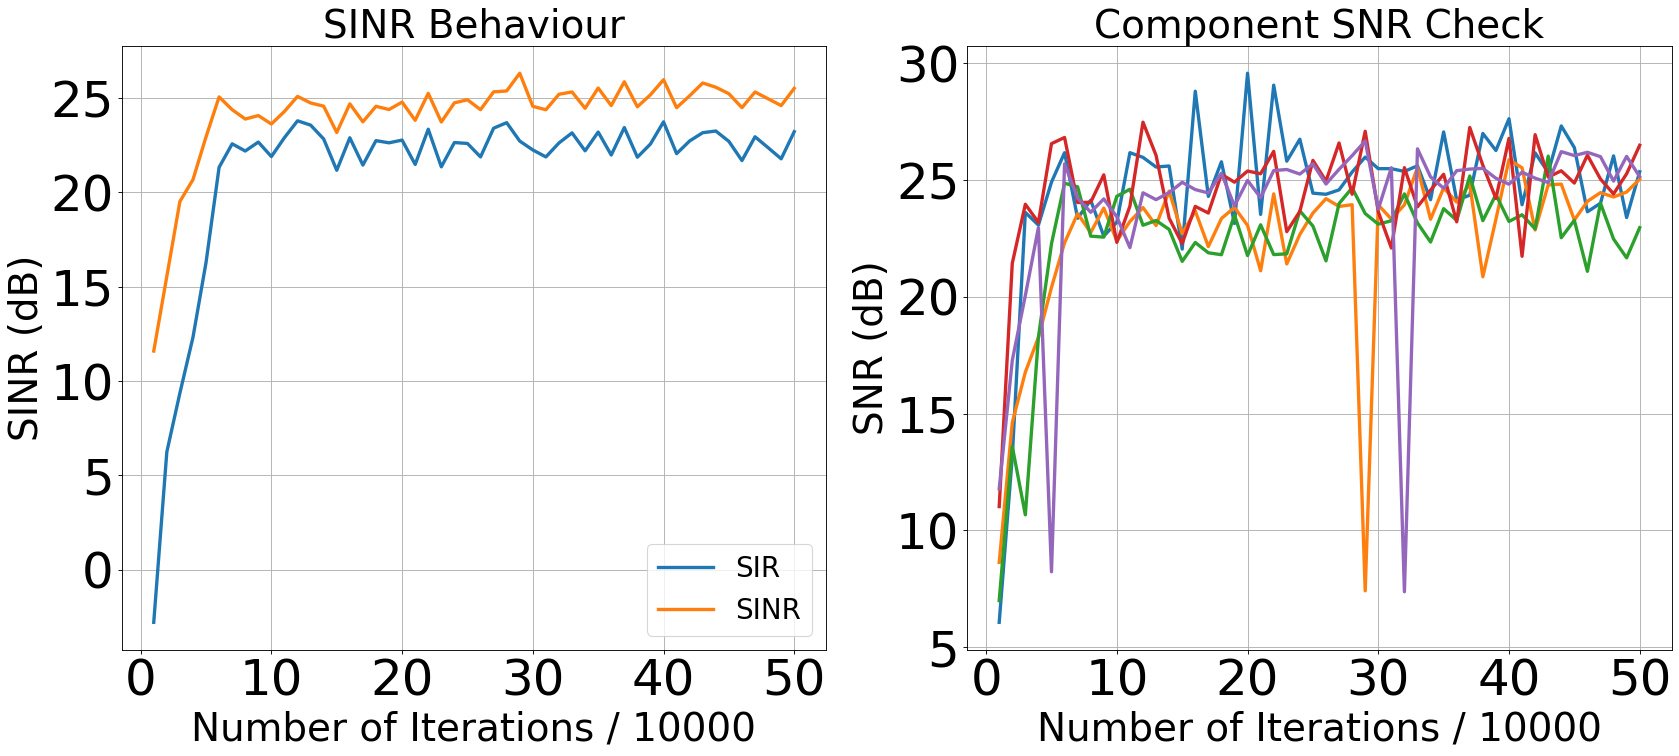

In [6]:
model.fit_batch_nnantisparse(X, n_epochs = 1, neural_dynamic_iterations = 500, lr_start = 0.5,
                             shuffle = True, debug_iteration_point = debug_iteration_point,plot_in_jupyter = True)

# Visualize SINR Convergence 

Final SINR: 25.516875315815394


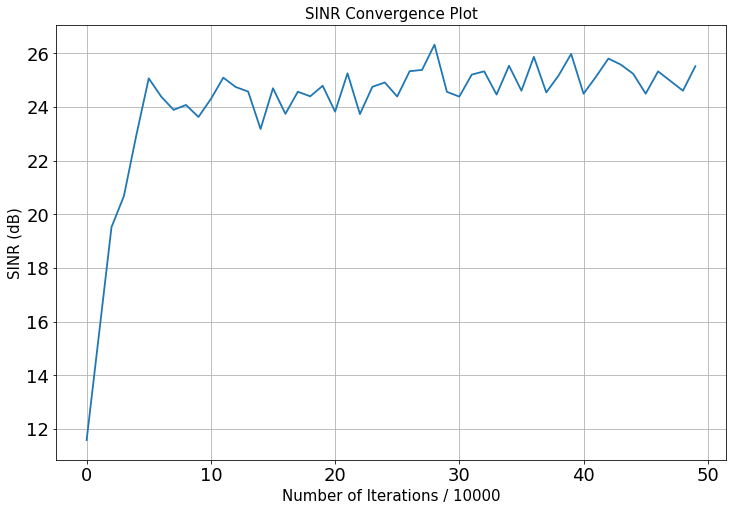

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SINR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SINR: {}'.format(np.array(model.SINR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINR = 10*np.log10(model.CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [26.5451222  24.0056082  26.50780371  7.9608043  26.51640167]

Overall SINR : 26.336238728251885


# Vizualize Extracted Signals Compared to Original Sources

In [9]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y.T).T
Y_.shape, X.shape, S.shape

((5, 500000), (10, 500000), (5, 500000))

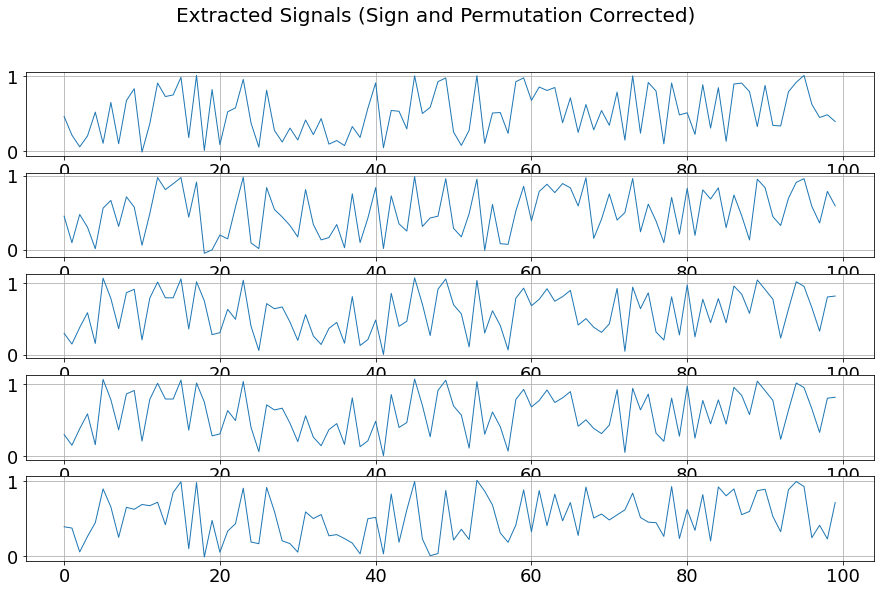

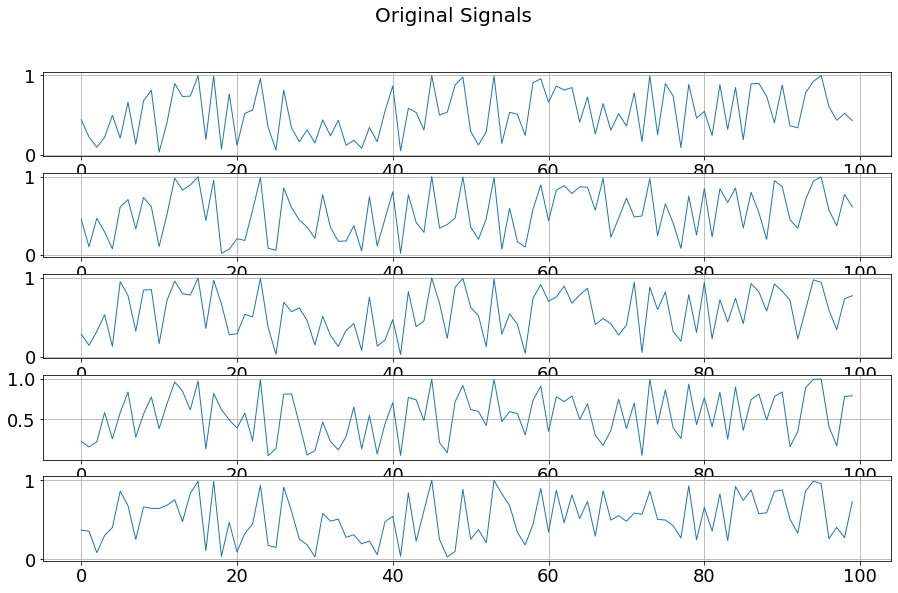

In [10]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)

In [36]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
snr(S.T.reshape(-1,1), Y_.reshape(-1,1))

array([14.67107579])

In [40]:
Out = Y_.T
r=S.shape[0]
G=np.dot(Out-np.reshape(np.mean(Out,1),(r,1)),np.linalg.pinv(S-np.reshape(np.mean(S,1),(r,1))))
indmax=np.argmax(np.abs(G),1)
# indmax = np.mod(model.find_permutation_between_source_and_estimation(Out.T, S.T),r)
GG=np.zeros((r,r))
for kk in range(r):
    GG[kk,indmax[kk]]=np.dot(Out[kk,:]-np.mean(Out[kk,:]),S[indmax[kk],:].T-np.mean(S[indmax[kk],:]))/np.dot(S[indmax[kk],:]-np.mean(S[indmax[kk],:]),S[indmax[kk],:].T-np.mean(S[indmax[kk],:]))#(G[kk,indmax[kk]])
ZZ=GG@(S-np.reshape(np.mean(S,1),(r,1)))+np.reshape(np.mean(Out,1),(r,1))
E=Out-ZZ
MSE=np.linalg.norm(E,'fro')**2
SigPow=np.linalg.norm(ZZ,'fro')**2
SINR=(SigPow/MSE)

In [41]:
indmax

array([0, 1, 2, 2, 4])

In [42]:
10*np.log10(SINR)

26.336238728251885

In [33]:
indmax=np.argmax(np.abs(G),1)
indmax = np.mod(find_permutation_between_source_and_estimation(Out.T, S.T),r)
indmax

array([0, 1, 3, 2, 4])

In [15]:
display_matrix(G)

<IPython.core.display.Math object>

In [16]:
Y_.shape

(500000, 5)

In [17]:
snr(Y_[:,3], Y_[:,4])

6.6212385159002975

In [18]:
10*np.log10(SINR)

14.972586478590358

In [19]:
find_permutation_between_source_and_estimation(Out.T, S.T)

array([0, 1, 8, 7, 4])

In [20]:
def find_permutation_between_source_and_estimation2(S,Y):
    """
    S    : Original source matrix
    Y    : Matrix of estimations of sources (after BSS or ICA algorithm)
    
    return the permutation of the source seperation algorithm
    """
    
    # perm = np.argmax(np.abs(np.corrcoef(S.T,Y.T) - np.eye(2*S.shape[1])),axis = 0)[S.shape[1]:]
    perm = np.argmax(np.abs(np.corrcoef(Y.T,S.T) - np.eye(2*S.shape[1])),axis = 0)[S.shape[1]:]
    return perm

In [21]:
np.mod(find_permutation_between_source_and_estimation2(Out.T, S.T), 5)

array([0, 1, 3, 2, 4])

In [22]:
10*np.log10(SINR)

14.972586478590358

In [23]:
indmax

array([0, 1, 2, 2, 4])

In [24]:
10*np.log10(model.CalculateSINR(Y_.T, S)[0])

26.336238728251885

In [25]:
display_matrix(G)

<IPython.core.display.Math object>

In [26]:
display_matrix(Wf @ A)

<IPython.core.display.Math object>

In [29]:
import mir_eval

In [31]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T

In [32]:
mir_eval.separation.bss_eval_sources(S, Y_,
                     compute_permutation=True)

(array([27.37287861, 24.66360862, 26.51884819, 23.44205136, 27.21062568]),
 array([28.41243776, 26.75447701, 34.05716439, 24.09418892, 28.6132886 ]),
 array([34.097901  , 28.85091648, 27.36268392, 32.01537745, 32.80737992]),
 array([0, 1, 2, 3, 4]))